# Modelo de Fatores Dinâmicos (DFM) - 1 fator: PCA + OLS estimation
---

> Modelo inicial, análise de resíduos, de sazonalidade, resultados iniciais e expansão do modelo com defasagens.

## Bibliotecas

In [253]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan

# Dados

In [254]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_tf.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()

# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tfpca.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando apenas um fator da base de dados, que iremos utilizar apenas para esse modelo

data_pca = data_pca['F1']

# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC')
new_data

C:\Users\HENRI\AppData\Local\Temp\ipykernel_9956\1621712112.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")


,gdp,F1
2002-03-01,0.388552,0.538712
2002-06-01,4.320709,-0.442968
2002-09-01,3.543887,0.424707
2002-12-01,-0.217573,-0.232993
2003-03-01,-4.746729,-1.958564
...,...,...
2021-09-01,2.578462,-0.342376
2021-12-01,-0.432211,1.693068
2022-03-01,-0.262737,-2.583732
2022-06-01,1.786737,-0.366600


In [255]:
# Criando defasagens dos fatores

# Lags Fator 1
new_data['F1_2'] = new_data['F1'].shift(2)
new_data['F1_4'] = new_data['F1'].shift(4)
new_data['F1_6'] = new_data['F1'].shift(6)

# Lags GDP
new_data['gdp_2'] = new_data['gdp'].shift(2)
new_data['gdp_4'] = new_data['gdp'].shift(4)

In [256]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

# Modelo
---

## Regressões

In [257]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ F1', data = train)
dfm = reg.fit()
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     12.32
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           0.000841
Time:                        11:44:16   Log-Likelihood:                -147.72
No. Observations:                  64   AIC:                             299.4
Df Residuals:                      62   BIC:                             303.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6504      0.309      2.104      0.0

In [258]:
# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_1fac = list()

reg = smf.ols('gdp ~ F1', data = new_data.loc['2002Q1':'2017Q4',])
dfm_1fac = reg.fit()
pred = dfm_1fac.predict(test.loc['2018Q1']).values[0]
list_1fac.append(pred)

for i, j in zip(test.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1', data = new_data.loc['2002Q1':i,])
    dfm_1fac = reg.fit()
    pred = dfm_1fac.predict(test.loc[j]).values[0]
    list_1fac.append(pred)

list_1fac

[-0.22511040983436714,
 0.4005661807538234,
 0.7457942889564265,
 1.538487097529694,
 -0.848911905731383,
 0.6780245190446317,
 1.5310301054433642,
 1.4159129248763256,
 -1.734814816310719,
 0.11742319870716672,
 2.4265091542848554,
 1.708499605250144,
 -1.47902998710919,
 0.6896171449922639,
 0.35110497785383715,
 1.8947610837029154,
 -1.2743738885487255,
 0.3557678171378729,
 1.4597835575410192]

## Perfomance

### Previsões

<AxesSubplot: >

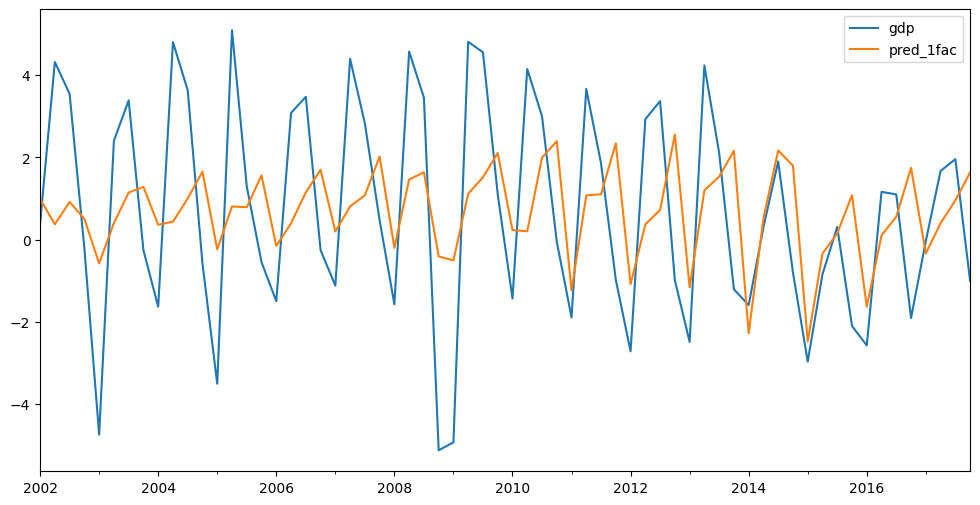

In [259]:
# Previsões IN-SAMPLE

forecasts_insample = pd.DataFrame()
forecasts_insample['gdp'] = y_train
forecasts_insample['pred_1fac'] = dfm.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

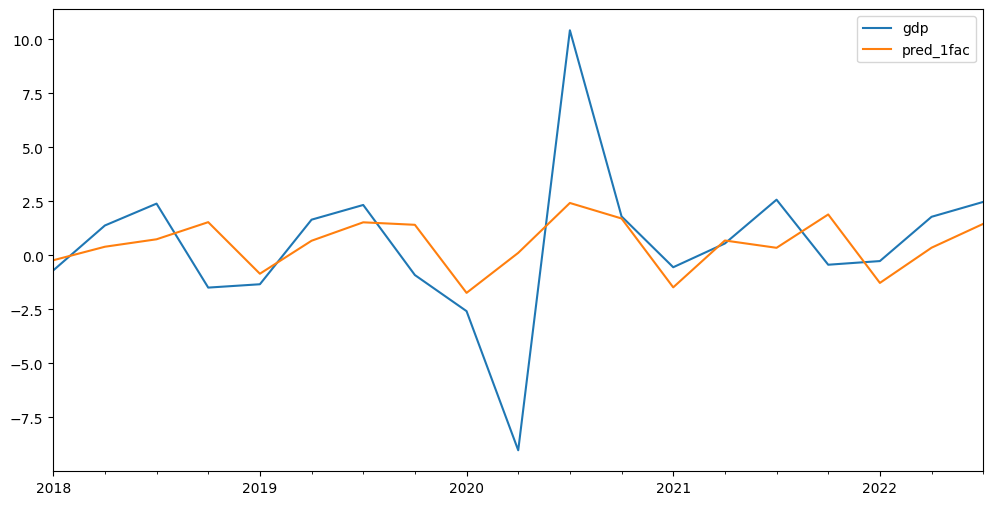

In [260]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['pred_1fac'] = list_1fac
forecasts_outsample.plot(figsize = (12,6))

### Métricas: RMSE, MAD e MAPE

In [261]:
# Métricas IN-SAMPLE

rmse_insample = np.sqrt(mean_squared_error(forecasts_insample['gdp'], forecasts_insample['pred_1fac']))
mae_insample = mean_absolute_error(forecasts_insample['gdp'], forecasts_insample['pred_1fac'])
mape_insample = mean_absolute_percentage_error(forecasts_insample['gdp'], forecasts_insample['pred_1fac'])
print(rmse_insample, mae_insample, mape_insample, sep = '\n\n')

2.433237180665312

2.087072438552906

2.1917929467962454


In [262]:
# Métricas OUT-OF-SAMPLE

rmse_outsample = np.sqrt(mean_squared_error(forecasts_outsample['gdp'], forecasts_outsample['pred_1fac']))
mae_outsample = mean_absolute_error(forecasts_outsample['gdp'], forecasts_outsample['pred_1fac'])
mape_outsample = mean_absolute_percentage_error(forecasts_outsample['gdp'], forecasts_outsample['pred_1fac'])
print(rmse_outsample, mae_outsample, mape_outsample, sep = '\n\n')

3.110558357815622

1.9938627254225636

1.2306100280650636


# Análise dos resíduos

## Autocorrelação

In [263]:
# Criando função para plotar as autocorrelações dos resíduos das regressões

def autocorr_plots(y1, y2, title1, title2):
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(211) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a primeira posição
    fig = plot_acf(y1, ax = ax1, title = title1)
    ax2 = fig.add_subplot(212) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a segunda posição
    fig = plot_acf(y2, ax=ax2, title = title2)

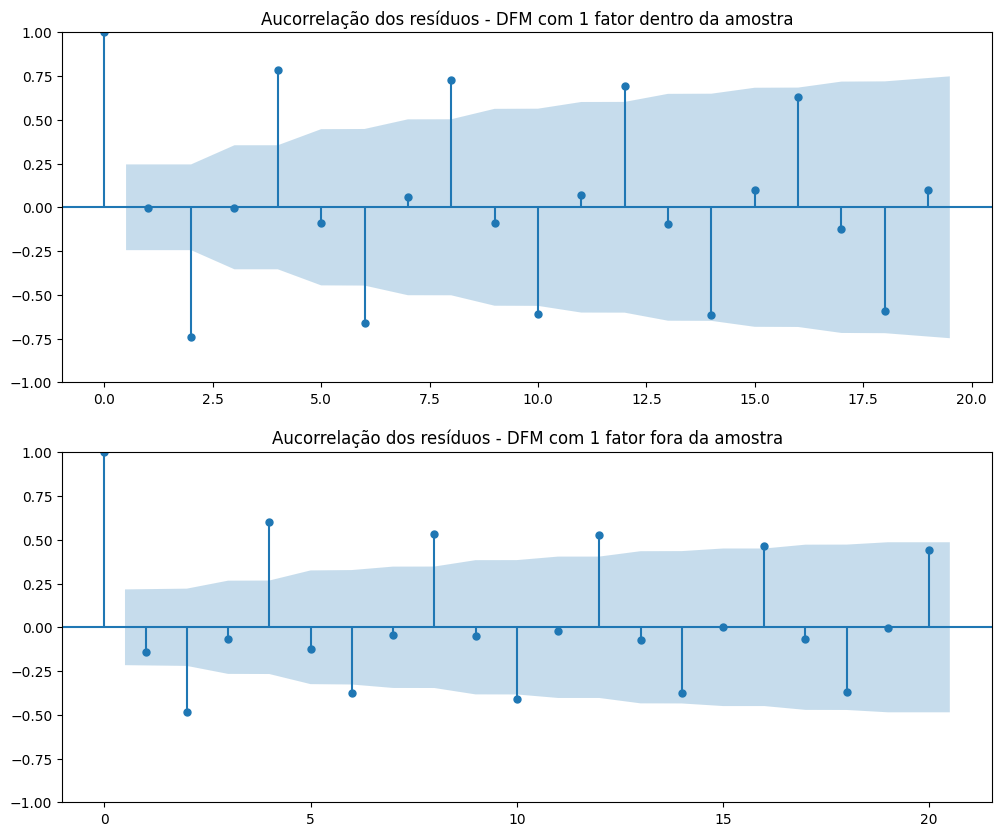

In [264]:
# Plotando a função de autocorrelação

autocorr_plots(dfm.resid, dfm_1fac.resid,
               'Aucorrelação dos resíduos - DFM com 1 fator dentro da amostra',
               'Aucorrelação dos resíduos - DFM com 1 fator fora da amostra')

In [265]:
# Teste de Breusch-Godfray para autocorrelação dos erros - IN-SAMPLE

bg_result = acorr_breusch_godfrey(dfm, nlags = 8)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm.resid, lags = 8)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.0

    lb_stat  lb_pvalue
1    0.0005     0.9823
2   37.2125     0.0000
3   37.2127     0.0000
4   80.3885     0.0000
5   80.9618     0.0000
6  112.7133     0.0000
7  112.9688     0.0000
8  152.8831     0.0000


In [266]:
# Teste de Breusch-Godfray para autocorrelação dos erros - OUT-OF-SAMPLE 

bg_result = acorr_breusch_godfrey(dfm_1fac, nlags = 8)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm_1fac.resid, lags = 8)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.0

   lb_stat  lb_pvalue
1   1.7314     0.1882
2  22.1444     0.0000
3  22.5181     0.0001
4  54.7371     0.0000
5  56.0689     0.0000
6  68.9222     0.0000
7  69.1213     0.0000
8  95.6162     0.0000


## Heteroscedasticidade

In [267]:
# Teste de heteroscedasticidade - IN-SAMPLE

het_breuschpagan(dfm.resid.loc['2003Q1':'2017Q4',], X_train.loc['2003Q1':'2017Q4',])

MissingDataError: exog contains inf or nans

In [ ]:
# Teste de heteroscedasticidade - OUT-OF-SAMPLE

het_breuschpagan(dfm_1fac.resid.loc['2003Q1':'2022Q2',], new_data.loc['2003Q1':'2022Q2',])

(9.088162968622793,
 0.10559888459171718,
 1.5825721722353276,
 0.16464901025052564)

> Temos uma probabilidade de errar em aproximadamente 9% ao rejeitarmos a hipótese nula de que os erros não possuem heteroscedasticidade. Então, nossos erros são HOMOSCEDASTICOS.

## Distribuição e comportamento no tempo

<AxesSubplot: xlabel='date', ylabel='resid'>

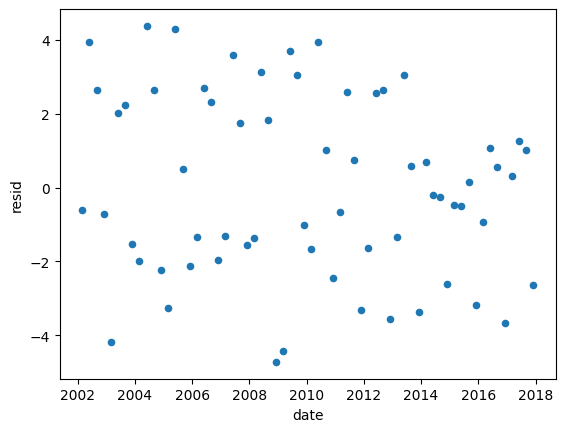

In [ ]:
# Modelo com dados apenas dentro da amostra

resids_plot = pd.DataFrame({'date':dfm.resid.index, 'resid':dfm.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

<AxesSubplot: xlabel='date', ylabel='resid'>

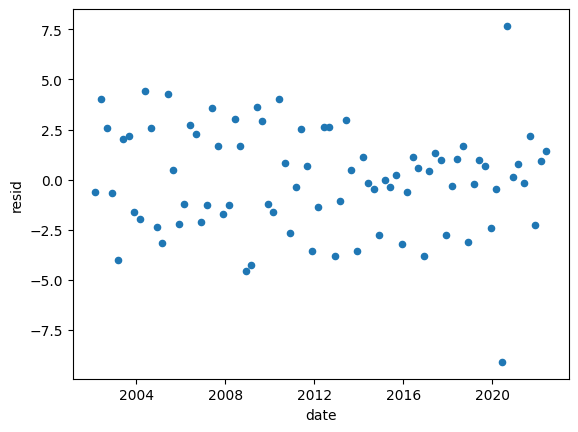

In [ ]:
# Out-of-sample

resids_plot = pd.DataFrame({'date':dfm_1fac.resid.index, 'resid':dfm_1fac.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

# Modelo: adicionando a dinâmica

In [ ]:
new_data.corr()

,gdp,F1,F1_2,F1_4,gdp_2,gdp_4
gdp,1.000000,0.434496,-0.250967,0.233515,-0.532687,0.575660
F1,0.434496,1.000000,-0.383052,0.756251,-0.225157,0.260021
F1_2,-0.250967,-0.383052,1.000000,-0.377003,0.433125,-0.224567
F1_4,0.233515,0.756251,-0.377003,1.000000,-0.249786,0.441066
gdp_2,-0.532687,-0.225157,0.433125,-0.249786,1.000000,-0.531063
gdp_4,0.575660,0.260021,-0.224567,0.441066,-0.531063,1.000000


## Regressões

In [ ]:
# Com dados da amostra - 2002 a 2017

reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_2 + F1_4 + F1_6', data = train)
dfm = reg.fit()
print(dfm.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     32.56
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           1.65e-16
Time:                        11:43:40   Log-Likelihood:                -88.513
No. Observations:                  58   AIC:                             193.0
Df Residuals:                      50   BIC:                             209.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4587      0.207      2.212      0.0

In [ ]:
# Modelo calibrado para prever resultados fora da amostra

# test_1fac = test[['F1']].copy()
list_1fac = list()

reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_2 + F1_4 + F1_6', data = new_data.loc['2002Q1':'2017Q4',])
dfm_1fac = reg.fit()
pred = dfm_1fac.predict(test.loc['2018Q1']).values[0]
list_1fac.append(pred)

for i, j in zip(test.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_2 + F1_4 + F1_6', data = new_data.loc['2002Q1':i,])
    dfm_1fac = reg.fit()
    pred = dfm_1fac.predict(test.loc[j]).values[0]
    list_1fac.append(pred)

list_1fac

[-0.14303231064599015,
 1.871914734352902,
 1.4088013204530472,
 -0.4812766281870433,
 -2.0884219510793396,
 2.221234105777201,
 2.9174978256482236,
 -0.7113439816544673,
 -2.284146368150357,
 0.9945226287469959,
 3.579978962482887,
 2.352338871152108,
 -3.0243287771543166,
 -5.334634211569049,
 3.1224009385406717,
 2.016400052706493,
 -1.7882231242526174,
 0.2762855358351448,
 3.5806744907376236]

## Performance

### Previsões

In [ ]:
forecasts_insample

,gdp,pred_1fac,pred_1fac_lags
2003-09-01,3.387499,1.145179,1.169773
2003-12-01,-0.257796,1.281669,0.054446
2004-03-01,-1.634150,0.360708,0.234817
2004-06-01,4.805899,0.435529,1.075137
2004-09-01,3.631217,0.998435,1.594871
2004-12-01,-0.585297,1.653896,1.232621
2005-03-01,-3.508910,-0.238837,-1.491087
2005-06-01,5.092743,0.804972,1.842944
2005-09-01,1.292770,0.787260,1.524509
2005-12-01,-0.550248,1.562482,0.348154


<AxesSubplot: >

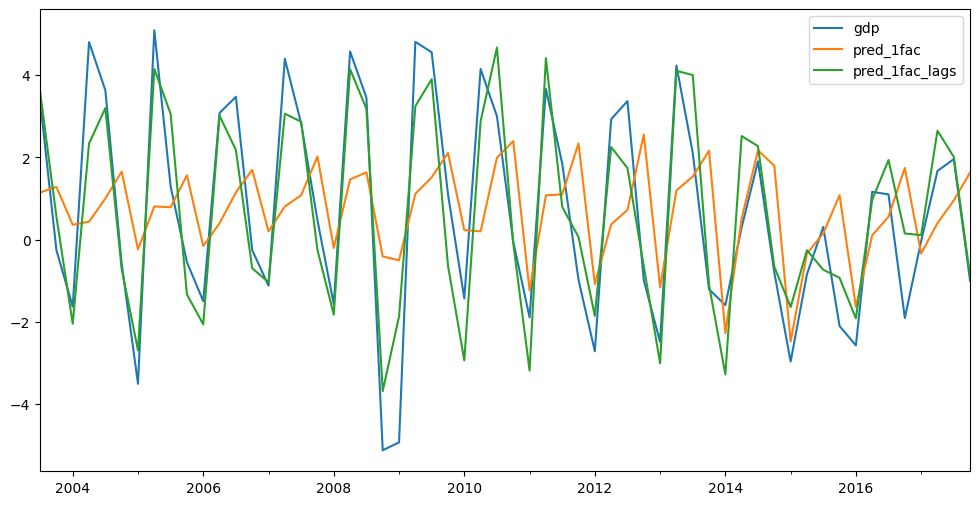

In [ ]:
# Previsões IN-SAMPLE

forecasts_insample['pred_1fac_lags'] = dfm.predict(X_train)
forecasts_insample.plot(figsize = (12,6))

<AxesSubplot: >

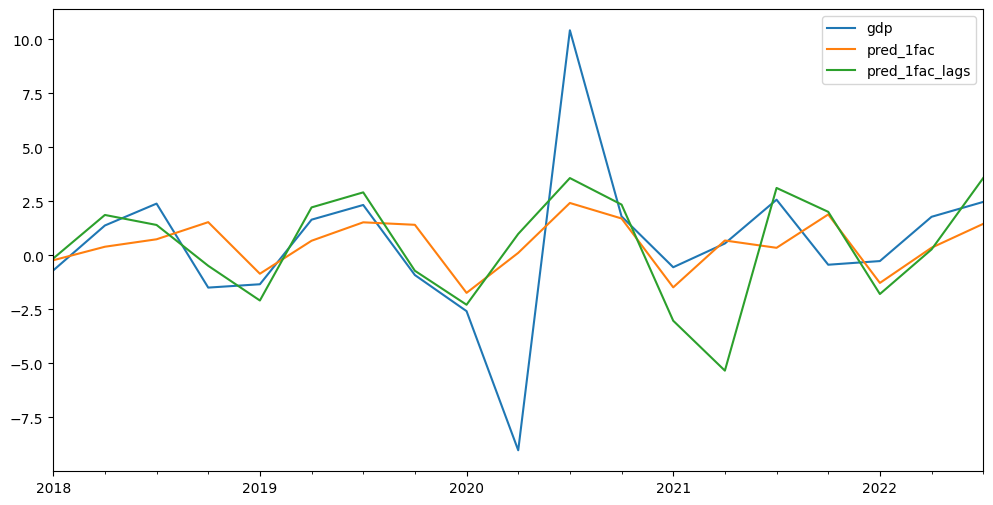

In [ ]:
# Previsões OUT-OF-SAMPLE

forecasts_outsample['pred_1fac_lags'] = list_1fac
forecasts_outsample.plot(figsize = (12,6))

### Métricas: RMSE, MAD, MAPE

In [ ]:
# Métricas IN-SAMPLE

forecasts_insample = forecasts_insample.dropna(axis = 0)
rmse_insample = np.sqrt(mean_squared_error(forecasts_insample['gdp'], forecasts_insample['pred_1fac_lags']))
mae_insample = mean_absolute_error(forecasts_insample['gdp'], forecasts_insample['pred_1fac_lags'].dropna())
mape_insample = mean_absolute_percentage_error(forecasts_insample['gdp'], forecasts_insample['pred_1fac_lags'].dropna())
print(rmse_insample, mae_insample, mape_insample, sep = '\n\n')

1.1179954367437854

0.8810606287279579

0.7581772290862097


In [ ]:
# Métricas OUT-OF-SAMPLE

rmse_outsample = np.sqrt(mean_squared_error(forecasts_outsample['gdp'], forecasts_outsample['pred_1fac_lags']))
mae_outsample = mean_absolute_error(forecasts_outsample['gdp'], forecasts_outsample['pred_1fac_lags'])
mape_outsample = mean_absolute_percentage_error(forecasts_outsample['gdp'], forecasts_outsample['pred_1fac_lags'])
print(rmse_outsample, mae_outsample, mape_outsample, sep = '\n\n')

3.2782555864442933

2.0176688188278358

1.78736703603968


# Análise dos resíduos

## Autocorrelação

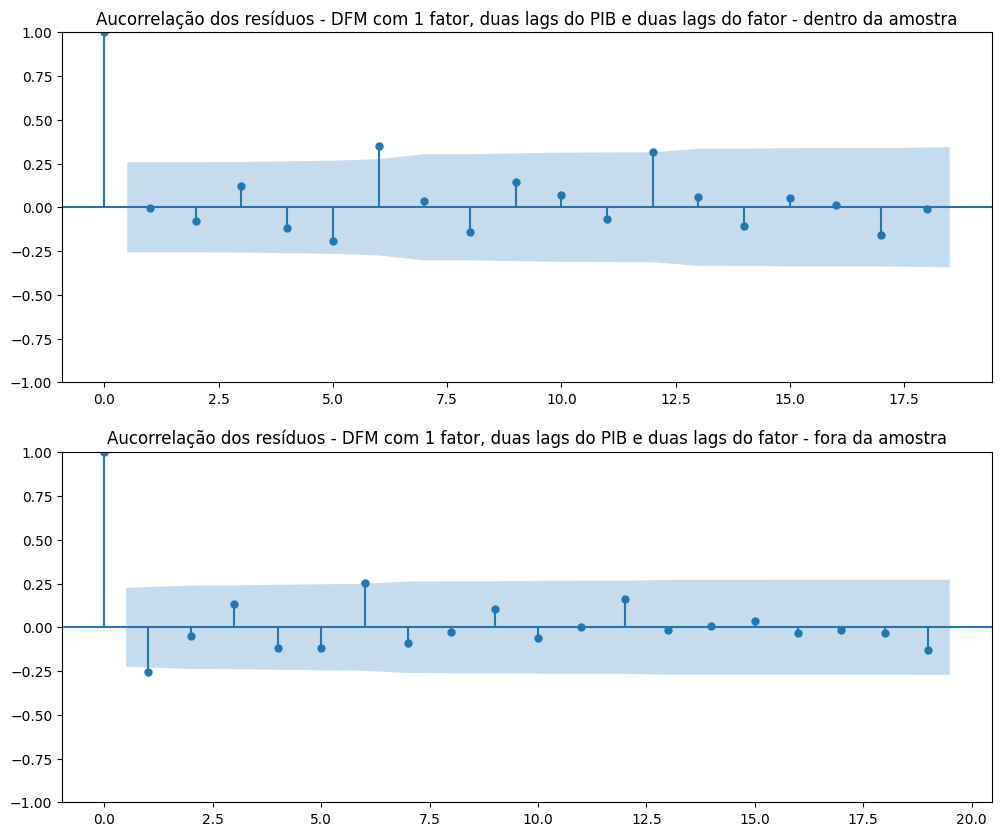

In [ ]:
# Plotando a função de autocorrelação

autocorr_plots(dfm.resid, dfm_1fac.resid,
               'Aucorrelação dos resíduos - DFM com 1 fator, duas lags do PIB e duas lags do fator - dentro da amostra',
               'Aucorrelação dos resíduos - DFM com 1 fator, duas lags do PIB e duas lags do fator - fora da amostra')

In [ ]:
# Teste de Breusch-Godfray para autocorrelação dos erros - IN-SAMPLE

bg_result = acorr_breusch_godfrey(dfm, nlags = 8)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm.resid, lags = 8)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.107

   lb_stat  lb_pvalue
1   0.0005     0.9816
2   0.3830     0.8257
3   1.2993     0.7293
4   2.2058     0.6980
5   4.6401     0.4614
6  12.8120     0.0461
7  12.8891     0.0749
8  14.3204     0.0738


In [ ]:
# Teste de Breusch-Godfray para autocorrelação dos erros - OUT-OF-SAMPLE 

bg_result = acorr_breusch_godfrey(dfm_1fac, nlags = 8)
bp_fpval = bg_result[3]

# Teste de Ljung-Box para autocorrelação dos erros

lb_result = acorr_ljungbox(dfm_1fac.resid, lags = 8)

# Resultados

print(f'BP fpval: {round(bp_fpval, 4)}\n')

print(round(lb_result, 4))

BP fpval: 0.0225

   lb_stat  lb_pvalue
1   5.0550     0.0246
2   5.2758     0.0715
3   6.6710     0.0832
4   7.8127     0.0987
5   9.0028     0.1090
6  14.4241     0.0252
7  15.1594     0.0340
8  15.2271     0.0549


## Heteroscedasticidade

In [ ]:
# Teste de heteroscedasticidade - IN-SAMPLE

het_breuschpagan(dfm.resid, X_train.loc['2003Q3':'2017Q4',])

(8.04985158665823, 0.1535095249588005, 1.396700162738059, 0.23365842127145747)

In [ ]:
# Teste de heteroscedasticidade - OUT-OF-SAMPLE

het_breuschpagan(dfm_1fac.resid, new_data.loc['2003Q3':'2022Q2',])

(5.332341529208704, 0.5019474468219596, 0.7437865263104881, 0.6357804278872059)

<AxesSubplot: xlabel='date', ylabel='resid'>

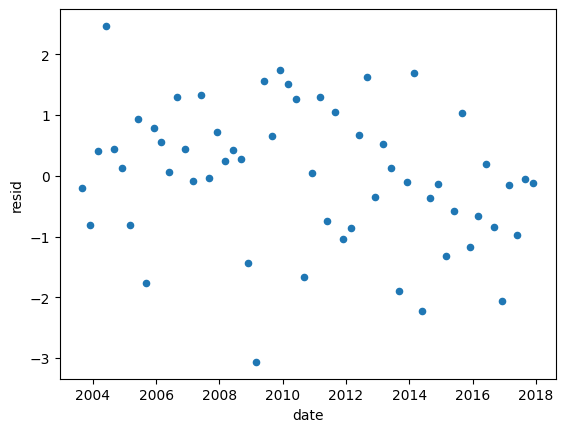

In [ ]:
# Modelo com dados apenas dentro da amostra

resids_plot = pd.DataFrame({'date':dfm.resid.index, 'resid':dfm.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')

<AxesSubplot: xlabel='date', ylabel='resid'>

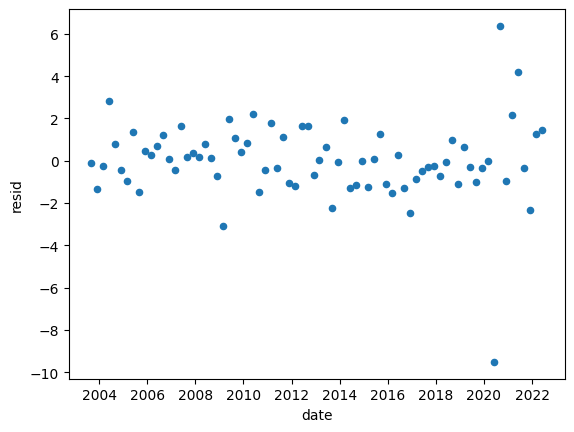

In [ ]:
# Out-of-sample

resids_plot = pd.DataFrame({'date':dfm_1fac.resid.index, 'resid':dfm_1fac.resid})
resids_plot.plot.scatter(x = 'date', y = 'resid')